In [178]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

import numpy as np
import pandas as pd
import missingno as msno

from scipy.stats import spearmanr 

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook, tqdm


from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [179]:
df = pd.read_csv("LAUNDRY.csv") #read file
df_FS = df.copy()
df_FS.head()

,No,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,Attire,Shirt_Colour,shirt_type,Pants_Colour,pants_type,Wash_Item,Washer_No,Dryer_No,Spectacles
0,1,19/10/2015,20:17:50,malay,NaN,moderate,NaN,yes,young,big,red,casual,blue,short_sleeve,black,short,clothes,3,10,no
1,2,19/10/2015,20:28:42,indian,male,thin,32.0,no,no_kids,big,green,casual,NaN,short_sleeve,blue_jeans,long,NaN,6,9,no
2,3,19/10/2015,20:58:31,malay,female,NaN,30.0,no,no_kids,big,blue,casual,red,short_sleeve,black,long,NaN,4,10,no
3,4,19/10/2015,21:31:28,indian,male,thin,51.0,no,no_kids,NaN,black,casual,NaN,short_sleeve,yellow,short,clothes,5,9,no
4,5,19/10/2015,21:40:28,indian,male,moderate,34.0,no,no_kids,big,blue,casual,blue,short_sleeve,white,long,clothes,3,9,no


<AxesSubplot:>

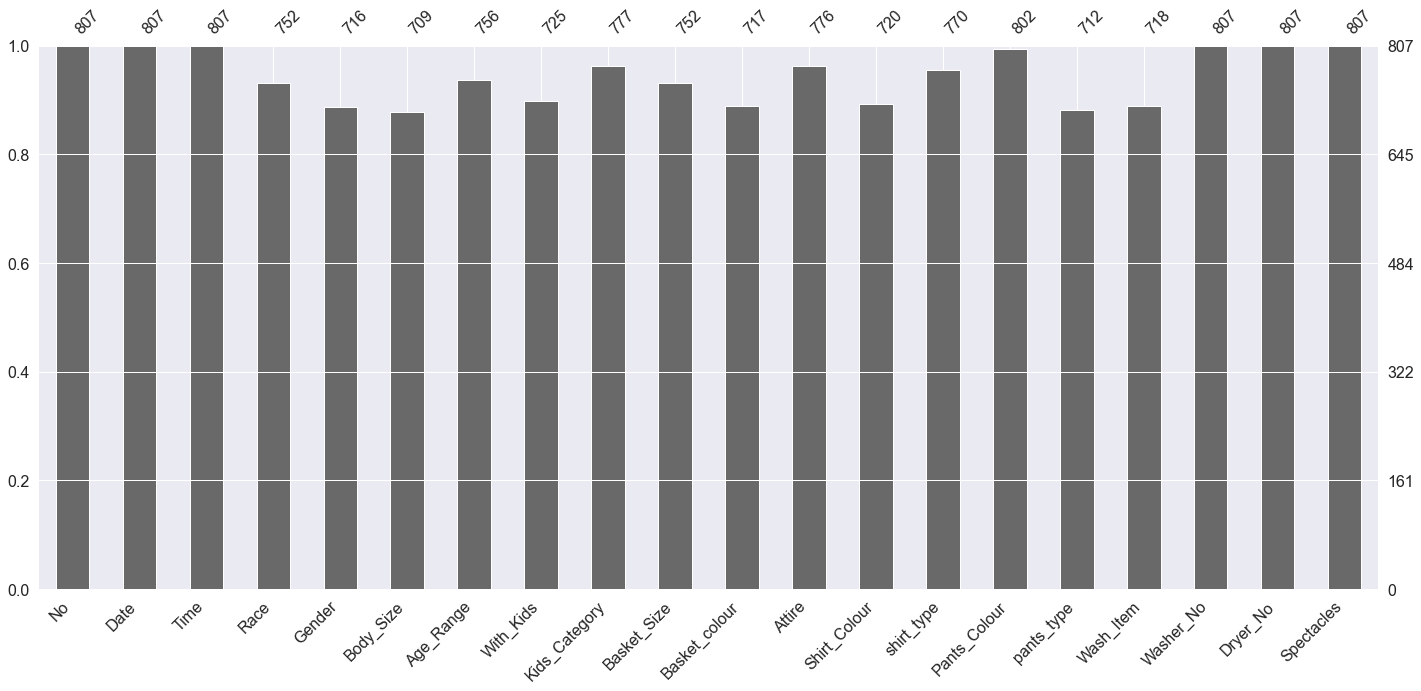

In [180]:
df_FS.isna().sum()
msno.bar(df_FS)

In [181]:
del df_FS['No']
df_FS.dropna(axis=0, subset=['Age_Range'], inplace=True)
df_FS['Gender'].fillna('male', inplace = True)
df_FS['Race'].fillna('Other', inplace = True)
df_FS['Body_Size'].fillna('Other', inplace = True)
df_FS['With_Kids'].fillna('Other', inplace = True)
df_FS['Kids_Category'].fillna('Other', inplace = True)
df_FS['Basket_Size'].fillna('big', inplace = True)
df_FS['Basket_colour'].fillna('Other', inplace = True)
df_FS['Shirt_Colour'].fillna('Other', inplace = True)
df_FS['shirt_type'].fillna('Other', inplace = True)
df_FS['Pants_Colour'].fillna('Other', inplace = True)
df_FS['pants_type'].fillna('long', inplace = True)
df_FS['Wash_Item'].fillna('Other', inplace = True)
df_FS['Attire'].fillna('Other', inplace = True)

df_FS.info()
df_section3=df_FS.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 1 to 806
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           756 non-null    object 
 1   Time           756 non-null    object 
 2   Race           756 non-null    object 
 3   Gender         756 non-null    object 
 4   Body_Size      756 non-null    object 
 5   Age_Range      756 non-null    float64
 6   With_Kids      756 non-null    object 
 7   Kids_Category  756 non-null    object 
 8   Basket_Size    756 non-null    object 
 9   Basket_colour  756 non-null    object 
 10  Attire         756 non-null    object 
 11  Shirt_Colour   756 non-null    object 
 12  shirt_type     756 non-null    object 
 13  Pants_Colour   756 non-null    object 
 14  pants_type     756 non-null    object 
 15  Wash_Item      756 non-null    object 
 16  Washer_No      756 non-null    int64  
 17  Dryer_No       756 non-null    int64  
 18  Spectacles

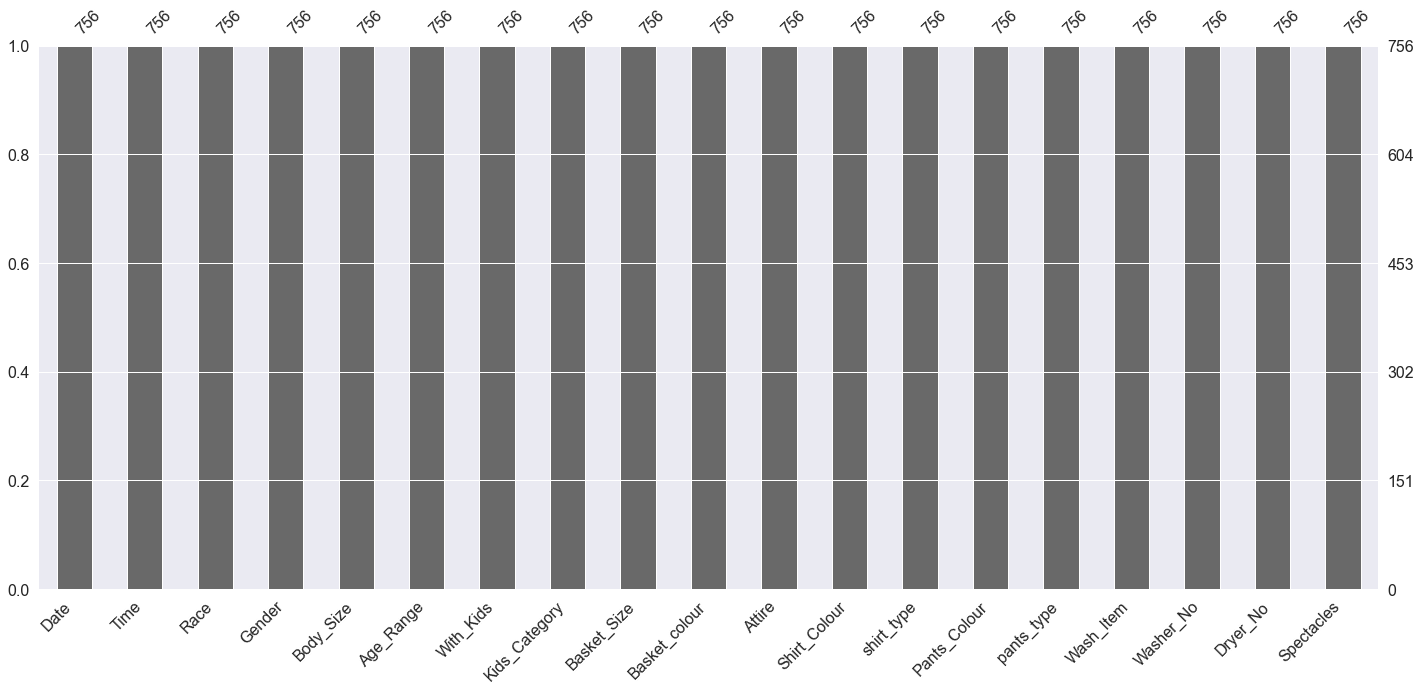

In [182]:
df_FS.isna().sum()
msno.bar(df_FS)
df_features = df_FS.copy() 
df_classification = df_FS.copy() 

Text(0, 0.5, 'Propotion of Customers')

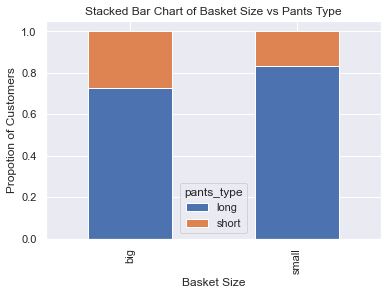

In [183]:
table=pd.crosstab(df_FS.Basket_Size,df_FS.pants_type)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Basket Size vs Pants Type')
plt.xlabel('Basket Size')
plt.ylabel('Propotion of Customers')

<AxesSubplot:xlabel='Washer_No', ylabel='Age_Range'>

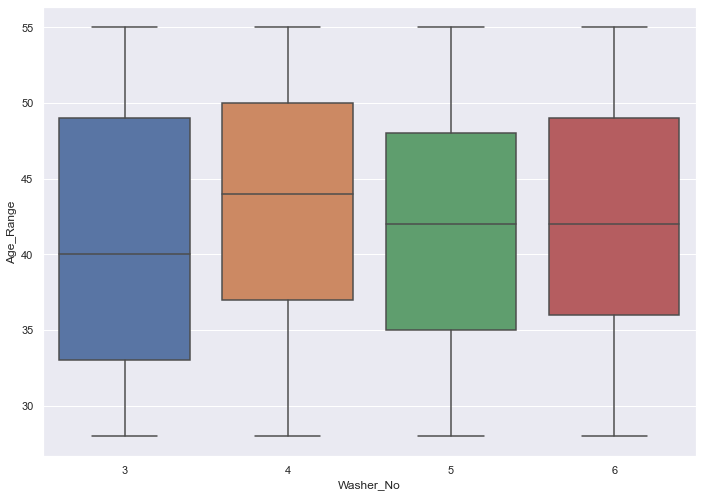

In [184]:
#boxplot
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.boxplot(data=df_FS, x="Washer_No", y="Age_Range", ax=ax)

<AxesSubplot:>

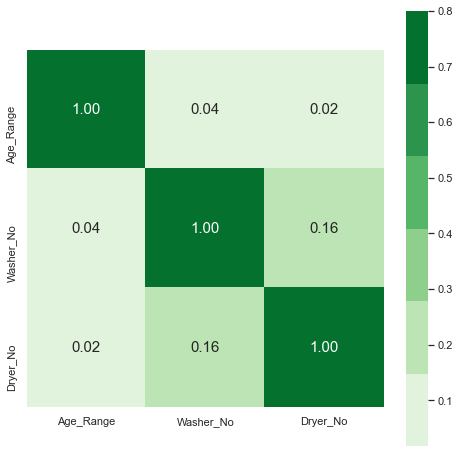

In [185]:
corr = df_FS.corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, vmax=.8, square=True, annot=True, fmt='.2f',
           annot_kws={'size': 15}, cmap=sns.color_palette("Greens"))

Text(0, 0.5, 'Frequency')

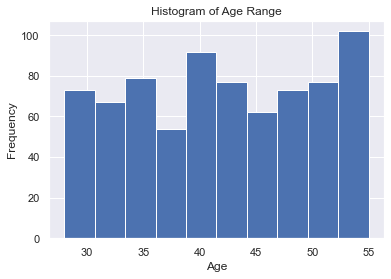

In [186]:
df_FS.Age_Range.hist()
plt.title('Histogram of Age Range')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Section2: Feature Selection

In [187]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [188]:
del df_features['Time']
del df_features['Date']
df_features.head()

,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,Attire,Shirt_Colour,shirt_type,Pants_Colour,pants_type,Wash_Item,Washer_No,Dryer_No,Spectacles
1,indian,male,thin,32.0,no,no_kids,big,green,casual,Other,short_sleeve,blue_jeans,long,Other,6,9,no
2,malay,female,Other,30.0,no,no_kids,big,blue,casual,red,short_sleeve,black,long,Other,4,10,no
3,indian,male,thin,51.0,no,no_kids,big,black,casual,Other,short_sleeve,yellow,short,clothes,5,9,no
4,indian,male,moderate,34.0,no,no_kids,big,blue,casual,blue,short_sleeve,white,long,clothes,3,9,no
5,Other,male,fat,50.0,no,no_kids,small,white,casual,brown,Other,blue_jeans,long,clothes,4,8,no


In [189]:
col_list = [col for col in df_features.columns.tolist() if df_features[col].dtype.name == "object"]
df_oh = df_features[col_list]
df_features = df_features.drop(col_list, 1)
df_oh = pd.get_dummies(df_oh)
df_features = pd.concat([df_features, df_oh], axis=1)
df_features.head()

,Age_Range,Washer_No,Dryer_No,Race_Other,Race_chinese,Race_foreigner,Race_indian,Race_malay,Gender_female,Gender_male,...,Pants_Colour_red,Pants_Colour_white,Pants_Colour_yellow,pants_type_long,pants_type_short,Wash_Item_Other,Wash_Item_blankets,Wash_Item_clothes,Spectacles_no,Spectacles_yes
1,32.0,6,9,0,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,1,0
2,30.0,4,10,0,0,0,0,1,1,0,...,0,0,0,1,0,1,0,0,1,0
3,51.0,5,9,0,0,0,1,0,0,1,...,0,0,1,0,1,0,0,1,1,0
4,34.0,3,9,0,0,0,1,0,0,1,...,0,1,0,1,0,0,0,1,1,0
5,50.0,4,8,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,1,0


In [190]:
y = df_features.Race_malay
X = df_features.drop("Race_malay", 1)
colnames = X.columns

# BORUTA

In [191]:
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth = 5)

feat_selector = BorutaPy(rf, n_estimators="auto", random_state = 1)

In [192]:
feat_selector.fit(X.values, y.values.ravel())

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=89, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x214B38C7940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x214B38C7940)

In [193]:
boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order= -1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features','Score'])
boruta_score = boruta_score.sort_values("Score", ascending = False)

In [194]:
print('---------Top 10----------')
display(boruta_score.head(10))

print('---------Bottom 10----------')
boruta_score.tail(10)

---------Top 10----------


,Features,Score
73,pants_type_short,1.00
3,Race_Other,1.00
4,Race_chinese,1.00
5,Race_foreigner,1.00
6,Race_indian,1.00
72,pants_type_long,1.00
55,shirt_type_short_sleeve,1.00
54,shirt_type_long sleeve,1.00
0,Age_Range,0.99
19,Kids_Category_toddler,0.97


---------Bottom 10----------


,Features,Score
67,Pants_Colour_pink,0.14
16,Kids_Category_Other,0.11
32,Basket_colour_purple,0.10
71,Pants_Colour_yellow,0.08
56,Pants_Colour_Other,0.07
60,Pants_Colour_blue,0.06
58,Pants_Colour_black,0.06
20,Kids_Category_toddler,0.03
61,Pants_Colour_blue,0.01
42,Shirt_Colour_black,0.00


Text(0.5, 1.0, 'Boruta Bottom 10 Features')

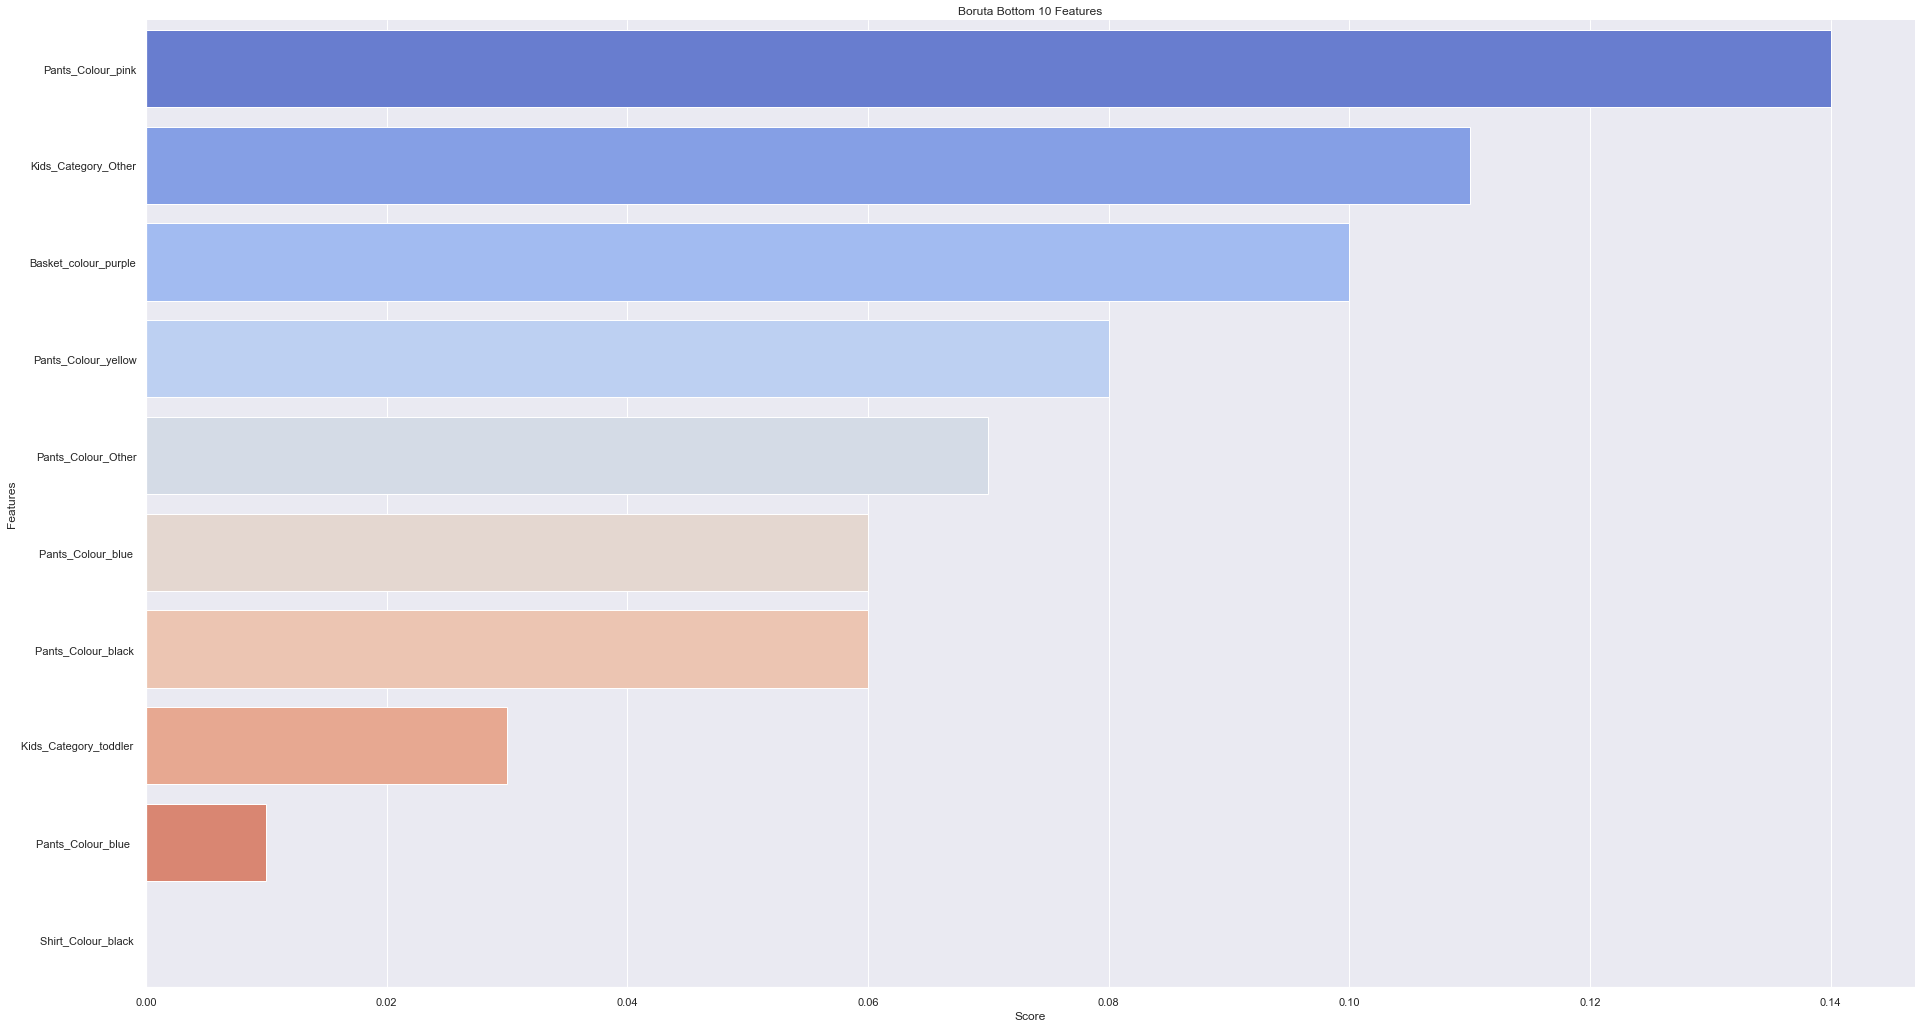

In [195]:
sns_boruta_plot = sns.catplot(x="Score", y="Features", data = boruta_score[-10:], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("Boruta Bottom 10 Features")

# RFE

In [196]:
rf = RandomForestClassifier(n_jobs=-1, class_weight="balanced_subsample", max_depth = 5, n_estimators = 50)
rf.fit(X, y)
rfe = RFECV(rf, min_features_to_select = 1, cv = 3)

In [197]:
rfe.fit(X, y)

RFECV(cv=3,
      estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                       max_depth=5, n_estimators=50,
                                       n_jobs=-1))

Text(0.5, 1.0, 'RFE Bottom 10 Features')

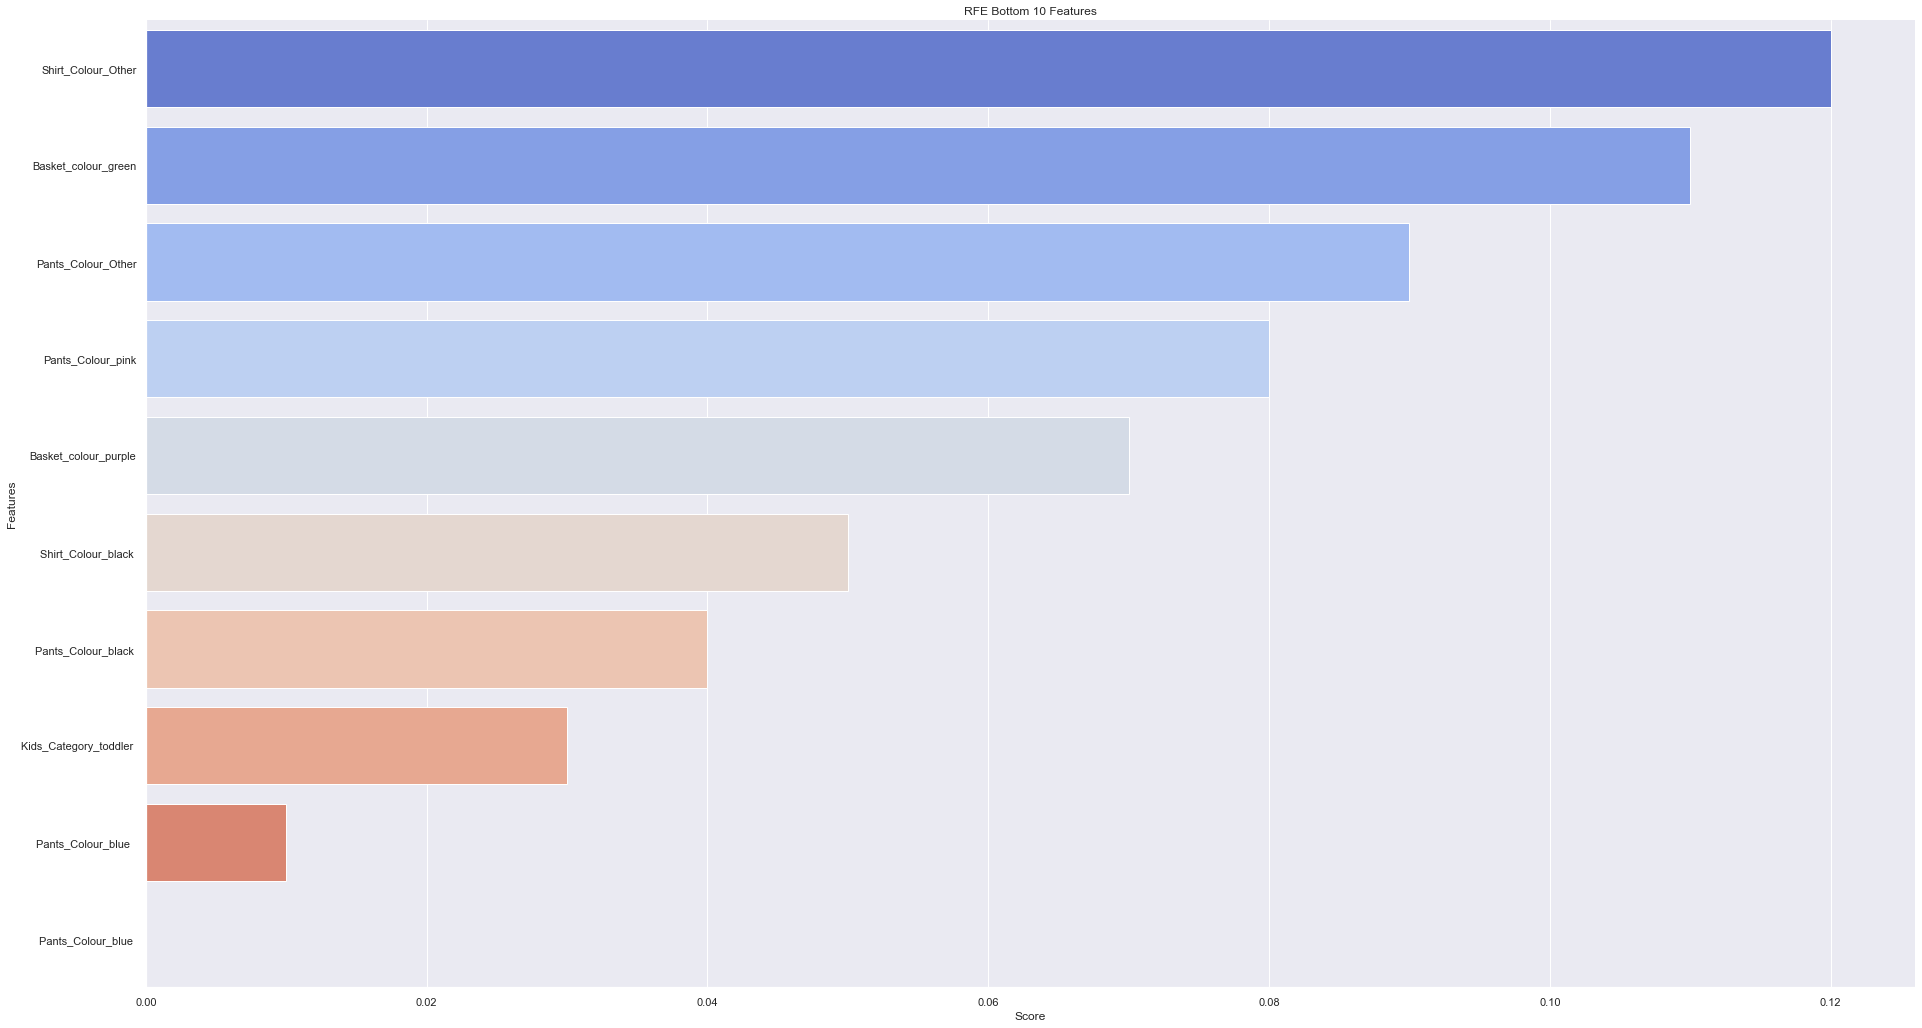

In [198]:
rfe_score = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)
rfe_score = pd.DataFrame(list(rfe_score.items()), columns=['Features', 'Score'])
rfe_score = rfe_score.sort_values("Score", ascending = False)

sns_rfe_plot = sns.catplot(x="Score", y="Features", data = rfe_score[-10:], kind = "bar", 
               height=14, aspect=1.9, palette='coolwarm')
plt.title("RFE Bottom 10 Features")

# Section 3 Classification

In [199]:
df_classification.head()
del df_classification['Time']
del df_classification['Date']

In [200]:
categorical = ['Race','Gender','Body_Size', 'With_Kids','Kids_Category','Basket_Size','Basket_colour','Attire','Shirt_Colour','shirt_type','Pants_Colour','pants_type','Wash_Item','Spectacles']
#dataset.info()
d = defaultdict(LabelEncoder)
df_classification[categorical] = df_classification[categorical].apply(lambda x: d[x.name].fit_transform(x.astype(str)))

In [201]:
X = df_classification.drop('pants_type', axis=1) 
y = df_classification['pants_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=10)

# KNN

In [202]:
k=11
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
print('KNN Score= {:.2f}'.format(knn.score(X_test, y_test)) )

KNN Score= 0.74


In [203]:
y_pred = knn.predict(X_test)

confussion_m = confusion_matrix(y_true=y_test, y_pred= y_pred)

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred, pos_label=0)))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred, pos_label=0)))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred, pos_label=0)))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

Precision= 0.76
Recall= 0.95
F1= 0.84
Accuracy= 0.74


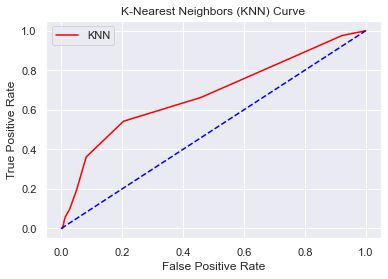

In [204]:
prob_KNN = knn.predict_proba(X_test)
prob_KNN = prob_KNN[:, 1]
fpr_knn, tpr_knn, thresholds_DT = roc_curve(y_test, prob_KNN) 

plt.plot(fpr_knn, tpr_knn, color='red', label='KNN') 
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbors (KNN) Curve')
plt.legend()

# NB

In [205]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

print('NB Score=', nb.score(X_test, y_test))

NB Score= 0.6732673267326733


In [206]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = nb.predict(X_test)

confussion_m = confusion_matrix(y_true=y_test, y_pred= y_pred)

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred, pos_label=0)))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred, pos_label=0)))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred, pos_label=0)))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

Precision= 0.80
Recall= 0.73
F1= 0.76
Accuracy= 0.67


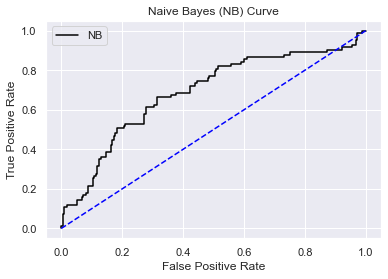

In [207]:
prob_NB = nb.predict_proba(X_test)
prob_NB = prob_NB[:, 1]
fpr_NB, tpr_NB, thresholds_DT = roc_curve(y_test, prob_NB) 

plt.plot(fpr_NB, tpr_NB, color='black', label='NB')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes (NB) Curve')
plt.legend()

Basket_Size

In [208]:
categorical = ['Race','Gender','Body_Size', 'With_Kids','Kids_Category','Basket_Size','Basket_colour','Attire','Shirt_Colour','shirt_type','Pants_Colour','pants_type','Wash_Item','Spectacles']
#dataset.info()
d = defaultdict(LabelEncoder)
df_classification[categorical] = df_classification[categorical].apply(lambda x: d[x.name].fit_transform(x.astype(str)))

In [209]:
X = df_classification.drop('Basket_Size', axis=1) 
y = df_classification['Basket_Size']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=10)

KNN

In [210]:
k=11
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train)
print('KNN Score= {:.2f}'.format(knn.score(X_test, y_test)) )

KNN Score= 0.93


In [211]:
y_pred = knn.predict(X_test)

confussion_m = confusion_matrix(y_true=y_test, y_pred= y_pred)

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred, pos_label=0)))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred, pos_label=0)))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred, pos_label=0)))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

Precision= 0.93
Recall= 1.00
F1= 0.96
Accuracy= 0.93


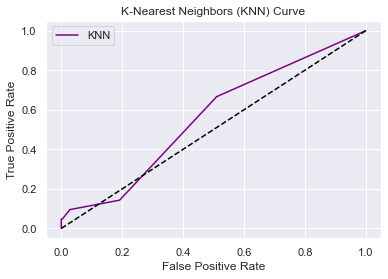

In [212]:
prob_KNN = knn.predict_proba(X_test)
prob_KNN = prob_KNN[:, 1]
fpr_knn, tpr_knn, thresholds_DT = roc_curve(y_test, prob_KNN) 

plt.plot(fpr_knn, tpr_knn, color='purple', label='KNN') 
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Nearest Neighbors (KNN) Curve')
plt.legend()

NB

In [213]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

print('NB Score=', nb.score(X_test, y_test))

NB Score= 0.9240924092409241


In [214]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = nb.predict(X_test)

confussion_m = confusion_matrix(y_true=y_test, y_pred= y_pred)

print('Precision= {:.2f}'.format(precision_score(y_test, y_pred, pos_label=0)))
print('Recall= {:.2f}'. format(recall_score(y_test, y_pred, pos_label=0)))
print('F1= {:.2f}'. format(f1_score(y_test, y_pred, pos_label=0)))
print('Accuracy= {:.2f}'. format(accuracy_score(y_test, y_pred)))

Precision= 0.94
Recall= 0.98
F1= 0.96
Accuracy= 0.92


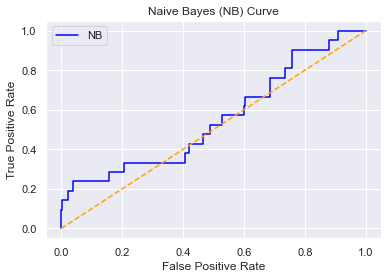

In [215]:
prob_NB = nb.predict_proba(X_test)
prob_NB = prob_NB[:, 1]
fpr_NB, tpr_NB, thresholds_DT = roc_curve(y_test, prob_NB) 

plt.plot(fpr_NB, tpr_NB, color='blue', label='NB')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes (NB) Curve')
plt.legend()